In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../../'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import jax
import jax.numpy as jnp
import jax.random as rnd
import jax.experimental.optimizers as opt
import jax.scipy as jsp

from tqdm import tqdm

from rationality import dynamics as dyn, objectives as obj, distributions as dst,\
    controllers as ctl, simulate as sim, utils as utils

from typing import Tuple

In [3]:
save_data = False

In [4]:
key = rnd.PRNGKey(0)
prior_samples = 10000
trials = 100
horizon = 12  # try 10 to 12

percentile = 95

isc_samples = 10000

svmpc_samples = 16
svmpc_bw = 'dynamic'
svmpc_iters = 10000
svmpc_opt = opt.adam(1e-5)

noise_style = 'fixed'
noise_scales = [0.1, 0.1, 0.01, 0.01, 0.01, 0.01]
noise_states = [0, 1, 2, 3, 4, 5]

inv_temps = jnp.concatenate([jnp.array([0.0]), jnp.exp(jnp.linspace(-6, 6, 20)), jnp.array([jnp.inf])])
prior_ic_cov = jnp.diag(jnp.array([1e-1, 1e-1, 1e-3, 1e-2, 1e-2, 1e-4]) ** 2)

In [5]:
dt = 0.3  # try ~0.2

Q = jnp.eye(6)
R = 0.1 * jnp.eye(2)
Qf = 100 * jnp.eye(6)

ic = jnp.array([1.0, -1.0, 0.0, 0.0, 0.0, 0.0])
ic_cov = prior_ic_cov

In [6]:
objective = obj.quadratic(Q, R, Qf)
dynamics = dyn.crazyflie2d(dt)
linearized_dynamics = dyn.linear(*dyn.linearize(dynamics, jnp.zeros(6),
                                                jnp.array([dynamics.params.hover_force, 0.0]), 0))

prob = ctl.problem(linearized_dynamics, objective, horizon)

In [7]:
key, subkey = rnd.split(key)

n = prob.num_states
m = prob.num_inputs

lqr = ctl.lqr.create(prob)
prior_sim = sim.compile_simulation(prob, lqr)
prior_ics = jax.vmap(lambda k: rnd.multivariate_normal(k, ic, prior_ic_cov),
                     out_axes=-1)(rnd.split(subkey, trials))

prior_states, prior_inputs, prior_costs = jax.vmap(lambda x: sim.run(x, jnp.zeros((n, horizon)), prior_sim, prob,
                                                                     lqr), in_axes=1, out_axes=-1)(prior_ics)

In [8]:
key, subkey = rnd.split(key)

# prior_cov = jnp.diag(jnp.array([1e-2, 1e-5] * horizon) ** 2)
#
# prior_params = [dst.GaussianParams(jnp.pad(prior_inputs.mean(axis=2)[:, t:].flatten(order='F'),
#                                            (0, t * prob.num_inputs)), prior_cov) for t in range(horizon)]

prior_covs = jnp.stack(
    [jsp.linalg.block_diag(jnp.cov(prior_inputs[:, t:, :].reshape((m * (horizon - t), trials), order='F')),
                           0 * jnp.eye(t * m)) + 1e-11 * jnp.eye(horizon * m)
     for t in range(horizon)], axis=-1)

prior_params = [dst.GaussianParams(jnp.pad(prior_inputs.mean(axis=2)[:, t:].flatten(order='F'),
                                           (0, t * prob.num_inputs)), prior_covs[:, :, t])
                for t in range(horizon)]

isc = ctl.isc.create(prob, jnp.inf, isc_samples, subkey, dst.GaussianPrototype(prob.num_inputs * horizon), prior_params)
svmpcc = ctl.svmpcc.create(prob, jnp.inf, subkey, svmpc_bw, svmpc_samples, dst.GaussianPrototype(prob.num_inputs * horizon),
                         prior_params, svmpc_opt, svmpc_iters)

In [9]:
est_noise = jnp.zeros((n, horizon, trials))

if noise_style.lower() == 'max':
    for state, scale in zip(noise_states, noise_scales):
        key, subkey = rnd.split(key)
        stddev = (scale * jnp.max(jnp.abs(prior_states[state, :, :])))
        est_noise = est_noise.at[state, :, :].set(stddev * rnd.normal(subkey, (horizon, trials)))
        print(f'Estimation Noise for state {state} is N(0, {stddev ** 2:.3f}).')

elif noise_style.lower() == 'fixed':
    for state, scale in zip(noise_states, noise_scales):
        key, subkey = rnd.split(key)
        est_noise = est_noise.at[state, :, :].set(scale * rnd.normal(subkey, (horizon, trials)))
        print(f'Estimation Noise for state {state} is N(0, {scale ** 2:.2e}).')
else:
    raise ValueError(f"Noise style must be one of: 'max', 'varying', 'fixed'")

Estimation Noise for state 0 is N(0, 4.00e-02).
Estimation Noise for state 1 is N(0, 4.00e-02).
Estimation Noise for state 2 is N(0, 4.00e-04).
Estimation Noise for state 3 is N(0, 4.00e-04).
Estimation Noise for state 4 is N(0, 4.00e-04).
Estimation Noise for state 5 is N(0, 4.00e-04).


In [10]:
key, subkey = rnd.split(key)

n = prob.num_states
m = prob.num_inputs

ic_samples = jax.vmap(lambda k: rnd.multivariate_normal(k, ic, ic_cov), out_axes=-1)(rnd.split(subkey, trials))

In [11]:
lqr_sim = sim.compile_simulation(prob, lqr)
isc_sim = sim.compile_simulation(prob, isc)
svmpc_sim = sim.compile_simulation(prob, svmpcc)

lqr_sim_with_noise = jax.jit(lambda ic_samples, noise: lqr_sim(ic_samples, noise, prob.params, lqr.params))

isc_sim_with_noise = jax.jit(lambda ic_samples, inv_temp, key, noise:
                             isc_sim(ic_samples, noise, prob.params, ctl.isc.ISCParams(inv_temp, key)))

svmpc_sim_with_noise = jax.jit(lambda ic_samples, inv_temp, key, noise:
                               svmpc_sim(ic_samples, noise, prob.params,
                                        ctl.svmpc.svmpcParams(inv_temp, key,
                                                              jnp.nan if svmpc_bw == 'dynamic' else svmpc_bw)))

In [12]:
def controller_stats(full_costs: jnp.ndarray, part_costs: jnp.ndarray,
                     percentile: float) -> Tuple[float, float, float, float]:
    full_cumm_costs = full_costs.sum(axis=0)
    full_inner_percentile = jnp.percentile(full_cumm_costs, percentile)
    full_selected = full_cumm_costs[full_cumm_costs <= full_inner_percentile]
    full_mean = full_selected.mean()
    full_std = full_selected.std()

    part_cumm_costs = part_costs.sum(axis=0)
    part_inner_percentile = jnp.percentile(part_cumm_costs, percentile)
    part_selected = part_cumm_costs[part_cumm_costs <= part_inner_percentile]
    part_mean = part_selected.mean()
    part_std = part_selected.std()

    return full_mean, full_std, part_mean, part_std


In [13]:
from IPython.display import clear_output

isc_full_states = []
isc_full_inputs = []
isc_full_costs = []

isc_part_states = []
isc_part_inputs = []
isc_part_costs = []

svmpc_full_states = []
svmpc_full_inputs = []
svmpc_full_costs = []

svmpc_part_states = []
svmpc_part_inputs = []
svmpc_part_costs = []

print(f'        name\t\t                part-obs        \t\tfull-obs        ')

lqrfull_states, lqrfull_inputs, lqrfull_costs = jax.vmap(lqr_sim_with_noise, in_axes=(1, 2), out_axes=-1)(ic_samples,
                                                                                                          jnp.zeros((n,
                                                                                                                     horizon,
                                                                                                                     trials)))
lqrpart_states, lqrpart_inputs, lqrpart_costs = jax.vmap(lqr_sim_with_noise, in_axes=(1, 2), out_axes=-1)(ic_samples,
                                                                                                          est_noise)

full_mean, full_std, part_mean, part_std = controller_stats(lqrfull_costs, lqrpart_costs, percentile)

print(f'{"lqr":^23}\t\t'
      f'{part_mean:>9.3f} ± {part_std:<9.4f}\t\t'
      f'{full_mean:>9.3f} ± {full_std:<9.4f}')

partial_means = []

for i, inv_temp in tqdm(enumerate(inv_temps)):
    key, subkey = rnd.split(key)

    full_results = jax.vmap(isc_sim_with_noise, in_axes=(1, 0, 0, 2), out_axes=-1)(ic_samples,
                                                                                   inv_temp * jnp.ones(trials),
                                                                                   rnd.split(subkey, trials),
                                                                                   jnp.zeros((n, horizon, trials)))

    part_results = jax.vmap(isc_sim_with_noise, in_axes=(1, 0, 0, 2), out_axes=-1)(ic_samples,
                                                                                   inv_temp * jnp.ones(trials),
                                                                                   rnd.split(subkey, trials),
                                                                                   est_noise)

    isc_full_states.append(full_results[0])
    isc_full_inputs.append(full_results[1])
    isc_full_costs.append(full_results[2])

    isc_part_states.append(part_results[0])
    isc_part_inputs.append(part_results[1])
    isc_part_costs.append(part_results[2])

    full_mean, full_std, part_mean, part_std = controller_stats(isc_full_costs[-1], isc_part_costs[-1], percentile)
    name = f'isc-{inv_temp:.3e}'

    #     tqdm.write(f'{name:^23}\t\t'
    #           f'{part_mean:>9.3f} ± {part_std:<9.4f}\t\t'
    #           f'{full_mean:>9.3f} ± {full_std:<9.4f}')

    full_results = jax.vmap(svmpc_sim_with_noise, in_axes=(1, 0, 0, 2), out_axes=-1)(ic_samples,
                                                                                     inv_temp * jnp.ones(trials),
                                                                                     rnd.split(subkey, trials),
                                                                                     jnp.zeros((n, horizon, trials)))

    part_results = jax.vmap(svmpc_sim_with_noise, in_axes=(1, 0, 0, 2), out_axes=-1)(ic_samples,
                                                                                     inv_temp * jnp.ones(trials),
                                                                                     rnd.split(subkey, trials),
                                                                                     est_noise)

    svmpc_full_states.append(full_results[0])
    svmpc_full_inputs.append(full_results[1])
    svmpc_full_costs.append(full_results[2])

    svmpc_part_states.append(part_results[0])
    svmpc_part_inputs.append(part_results[1])
    svmpc_part_costs.append(part_results[2])

    full_mean, full_std, part_mean, part_std = controller_stats(svmpc_full_costs[-1], svmpc_part_costs[-1], percentile)
    name = f'svc-{inv_temp:.3e}'

    tqdm.write(f'{name:^23}\t\t'
               f'{part_mean:>9.3f} ± {part_std:<9.4f}\t\t'
               f'{full_mean:>9.3f} ± {full_std:<9.4f}')

    jnp.savez('data.npz',
              lqrfull_states=lqrfull_states,
              lqrfull_inputs=lqrfull_inputs,
              lqrfull_costs=lqrfull_costs,

              lqrpart_states=lqrpart_states,
              lqrpart_inputs=lqrpart_inputs,
              lqrpart_costs=lqrpart_costs,

              svmpc_full_states=jnp.stack(svmpc_full_states, axis=-1),
              svmpc_full_inputs=jnp.stack(svmpc_full_inputs, axis=-1),
              svmpc_full_costs=jnp.stack(svmpc_full_costs, axis=-1),

              svmpc_part_states=jnp.stack(svmpc_part_states, axis=-1),
              svmpc_part_inputs=jnp.stack(svmpc_part_inputs, axis=-1),
              svmpc_part_costs=jnp.stack(svmpc_part_costs, axis=-1),

              isc_full_states=jnp.stack(isc_full_states, axis=-1),
              isc_full_inputs=jnp.stack(isc_full_inputs, axis=-1),
              isc_full_costs=jnp.stack(isc_full_costs, axis=-1),

              isc_part_states=jnp.stack(isc_part_states, axis=-1),
              isc_part_inputs=jnp.stack(isc_part_inputs, axis=-1),
              isc_part_costs=jnp.stack(isc_part_costs, axis=-1),

              inv_temps=inv_temps[:i + 1])

    partial_means.append(part_mean)

partial_means = jnp.array(partial_means)

        name		                part-obs        		full-obs        
          lqr          		   13.117 ± 3.1676   		    6.245 ± 0.0000   


  0%|          | 0/22 [00:00<?, ?it/s]

     svc-0.000e+00     		448102.844 ± 487268.0938		448102.844 ± 487268.0938
     svc-6.738e-03     		 1970.493 ± 1256.9264		 1899.701 ± 1179.6149
     svc-1.141e-02     		 1759.367 ± 1151.5472		 1996.837 ± 1353.4182
     svc-1.931e-02     		 1299.610 ± 1118.9490		 1300.989 ± 980.5040 
     svc-3.268e-02     		  981.654 ± 755.6959 		 1042.038 ± 764.9310 
     svc-5.531e-02     		 1022.316 ± 866.2883 		 1019.208 ± 970.1513 
     svc-9.363e-02     		 1045.394 ± 792.1014 		 1038.646 ± 886.5711 
     svc-1.585e-01     		  883.537 ± 716.4739 		  907.109 ± 708.0992 
     svc-2.683e-01     		  865.898 ± 647.6295 		  794.501 ± 571.7141 
     svc-4.541e-01     		  824.216 ± 665.1603 		  768.319 ± 608.4940 
     svc-7.686e-01     		  611.340 ± 471.6324 		  567.053 ± 474.0029 
     svc-1.301e+00     		  705.881 ± 626.6186 		  683.894 ± 685.6506 
     svc-2.202e+00     		  672.361 ± 524.2198 		  871.759 ± 886.9478 
     svc-3.728e+00     		  648.902 ± 532.3965 		  694.997 ± 620.1367 
     svc-6.310

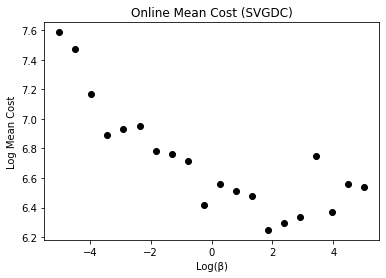

In [14]:
import shutil

if not utils.in_ipynb():
    if shutil.which('gnuplot') is not None:
        import termplotlib as tpl

        fig = tpl.figure()
        fig.plot(jnp.log(inv_temps), jnp.log(partial_means), width=80, height=25, xlabel='Log(β)',
                 title='Log Mean Part-Obs Cost (SVMPC)')
        fig.show()
    else:
        print("The program `gnuplot' is not installed. Skipping terminal plot.")
else:
    import matplotlib.pyplot as plt

    plt.figure()
    plt.plot(jnp.log(inv_temps), jnp.log(partial_means), 'ok')
    plt.title('Mean Part-Obs Cost (SVMPC)')
    plt.ylabel('Log Mean Cost')
    plt.xlabel('Log(β)')
    plt.show()

In [15]:
# if save_data:
#     import os
#     import pandas as pd
#
#     def make_df(states: jnp.ndarray, inputs: jnp.ndarray, costs: jnp.ndarray,
#                 name: str, beta: float, vis: str) -> pd.DataFrame:
#         cumm_costs = costs.sum(axis=0)
#
#         return pd.concat([pd.DataFrame({
#             'Controller' : pd.Series([name] * (horizon + 1)),
#             'Visibility' : pd.Series([vis] * (horizon + 1)),
#             'Discarded' : pd.Series([costs[:, trial].sum() > jnp.percentile(cumm_costs, percentile)] * (horizon + 1)),
#             'beta' : pd.Series([beta] * (horizon + 1)),
#             'Trial' : pd.Series([trial] * (horizon + 1)),
#             't' : pd.Series(list(range(horizon + 1))),
#             'x' : pd.Series(states[0, :, trial]),
#             'y' : pd.Series(states[1, :, trial]),
#             'theta' : pd.Series(states[2, :, trial]),
#             'x_dot' : pd.Series(states[3, :, trial]),
#             'y_dot' : pd.Series(states[4, :, trial]),
#             'theta_dot' : pd.Series(states[5, :, trial]),
#             'Thrust' : pd.Series(inputs[0, :, trial]),
#             'Moment' : pd.Series(inputs[1, :, trial]),
#             'Costs' : pd.Series(costs[:, trial]),
#             'Cumm. Costs' : pd.Series(costs[:, trial].cumsum())
#         }) for trial in range(trials)])
#
#     mp_full_df = make_df(mp_full_states, mp_full_inputs, mp_full_costs, 'LQR', jnp.nan, 'Full')
#     mp_part_df = make_df(mp_part_states, mp_part_inputs, mp_part_costs, 'LQR', jnp.nan, 'Part')
#
#     full_dfs = [mp_full_df] + [make_df(isc_full_states[i], isc_full_inputs[i], isc_full_costs[i], 'ISC', inv_temp, 'Full')
#                                for i, inv_temp in enumerate(inv_temps)]
#
#     part_dfs = [mp_part_df] + [make_df(isc_part_states[i], isc_part_inputs[i], isc_part_costs[i], 'ISC', inv_temp, 'Part')
#                                for i, inv_temp in enumerate(inv_temps)]
#
#     df = pd.concat(full_dfs + part_dfs)
#
#     if os.path.exists('../data/linearized_quad2d/data.pkl'):
#         os.remove('../data/linearized_quad2d/data.pkl')
#
#     df.to_pickle('../data/linearized_quad2d/data.pkl')